# 素因数分解アルゴリズムを学習する

この実習では**ショアのアルゴリズム**を学習します。名前を聞いたことがある人もいるかもしれませんが、ショアのアルゴリズム{cite}`shor,nielsen_chuang_qft_app`は最も有名な量子アルゴリズムと言っても良いでしょう。ショアのアルゴリズムの元になっている**量子位相推定**と呼ばれる手法を学んだ後、ショアのアルゴリズムの各ステップを実例とともに紹介します。最後に、Qiskitを使用してショアのアルゴリズムを実装し、実際に素因数分解を行ってみます。

```{contents} 目次
---
local: true
---
```

$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\modequiv}[3]{#1 \equiv #2 \pmod{#3}}$
$\newcommand{\modnequiv}[3]{#1 \not\equiv #2 \pmod{#3}}$

(shor_introduction)=
## はじめに

古典計算をはるかに上回る能力を持つ量子計算の一つの例として、最も広く知られているのがショアの量子計算アルゴリズムでしょう。このアルゴリズムが考える問題は、大きな正の数を二つの素数の積に分解するというもので、問題自体はシンプルです。しかし、古典計算では素因数分解の有効なアルゴリズムが知られておらず、数が大きくなると**指数関数的に計算量が増える**と予想されています。
ショアのアルゴリズムを用いれば、同じ問題を**多項式時間で解くことができる**と考えられています（一般的に、問題のサイズに対して多項式で増える計算時間で解くことができれば、それは有効なアルゴリズムだと見なされます）。

古典計算での素因数分解の難しさは、現在広く使われている鍵暗号技術の元になっています。なので、指数関数的に高速なショアのアルゴリズムが量子コンピュータで実現されれば、秘密の情報が暴かれる可能性があります。ショアのアルゴリズムが大きく注目される理由はそこにあります。

(qpe)=
## 量子位相推定

まず、ショアのアルゴリズムの元になっている「**量子位相推定」**（*Quantum Phase Estimation*, QPE）と呼ばれる手法について学びましょう。ショアのアルゴリズムを理解していけば、ショアのアルゴリズムの核心部分は、実はほぼQPEそのものであることが見えてくると思います。QPEの理解には「**量子フーリエ変換**」（*Quantum Fourier Transform*, QFT）の理解が欠かせませんが、QFTについては、この[実習](circuit_from_scratch.ipynb)の問題7、もしくは参考文献[1]を参照してください。

QPEはとても大事な計算手法で、ショアのアルゴリズムだけでなく、いろいろな量子アルゴリズムのサブルーチンとしても使われています。
%（モンテカルロサンプラーの[実習](mc_sampler.ipynb)でも出てきます）。

QPEが考える問題は、「あるユニタリー演算$U$に対して$U\ket{\psi}=e^{2\pi i\theta}\ket{\psi}$となる固有ベクトル$\ket{\psi}$が与えられるとして、その固有値$e^{2\pi i\theta}$の位相$\theta$を求めることができるか？」という問題です。

(qpe_1qubit)=
### 1量子ビットの位相推定
まず、下図にあるような量子回路を考えてみましょう。上側の量子ビットは$\ket{0}$、下側の量子ビットには$U$の固有ベクトル$\ket{\psi}$が初期状態として与えられているとします。

```{image} figs/qpe_1qubit.png
:alt: qpe_1qubit
:width: 300px
:align: center
```

この場合、量子回路の1-3の各ステップでの量子状態は、以下のように表現できます。

- ステップ 1 : $\frac{1}{\sqrt{2}}(\ket{0}\ket{\psi}+\ket{1}\ket{\psi})$
- ステップ 2 : $\frac{1}{\sqrt{2}}(\ket{0}\ket{\psi}+\ket{1} e^{2\pi i\theta}\ket{\psi})$
- ステップ 3 : $\frac{1}{2}\left[(1+e^{2\pi i\theta})\ket{0}+(1-e^{2\pi i\theta})\ket{1}\right]\ket{\psi}$

この状態で上側の量子ビットを測定すると、$|(1+e^{2\pi i\theta})/2|^2$の確率で0、$|(1-e^{2\pi i\theta})/2|^2$の確率で1を測定するでしょう。つまり、この確率の値から位相$\theta$を求めることができるわけです。
しかし、$\theta$の値が小さい場合（$\theta\ll1$）、ほぼ100%の確率で0を測定し、ほぼ0％の確率で1を測定することになるため、100%あるいは0%からのずれを精度良く決めるためには測定を何度も繰り返す必要が出てきます。これではあまり優位性を感じませんね。。

```{hint}
この制御$U$ゲートの部分がショアのアルゴリズムの「オラクル」に対応しています。その後ろには逆量子フーリエ変換が来ますが、1量子ビットの場合は$H$ゲート（$H=H^\dagger$）です。つまり、1量子ビットの量子フーリエ変換は$H$ゲートそのものということですね。
```

本題に戻って、では少ない測定回数でも精度良く位相を決める方法は、何か考えられるでしょうか。。

(qpe_nqubit)=
### $n$量子ビットの位相推定
そこで、上側のレジスタを$n$量子ビットに拡張した量子回路（下図）を考えてみましょう。

```{image} figs/qpe_wo_iqft.png
:alt: qpe_wo_iqft
:width: 500px
:align: center
```

それに応じて、下側のレジスタにも$U$を繰り返し適用することになりますが、鍵になるのは$U$を2の羃乗回適用するところです。それがどういう意味を持つのかを理解するために、準備として$U^{2^x}\ket{\psi}$が以下のように書けることを見ておきます（まあ当然と言えば当然ですが）。

$$
\begin{aligned}
U^{2^x}\ket{\psi}&=U^{2^x-1}U\ket{\psi}\\
&=U^{2^x-1}e^{2\pi i\theta}\ket{\psi}\\
&=U^{2^x-2}e^{2\pi i\theta2}\ket{\psi}\\
&=\cdots\\
&=e^{2\pi i\theta2^x}\ket{\psi}
\end{aligned}
$$

この量子回路に対して、同様に1, 2, ... $n+1$の各ステップでの量子状態を追跡していくと、以下のようになることが分かります。

- ステップ 1 : $\frac{1}{\sqrt{2^n}}(\ket{0}+\ket{1})^{\otimes n}\ket{\psi}$
- ステップ 2 : $\frac{1}{\sqrt{2^n}}(\ket{0}+e^{2\pi i\theta2^{n-1}}\ket{1})(\ket{0}+\ket{1})^{\otimes n-1}\ket{\psi}$
- $\cdots$
- ステップ $n+1$ : $\frac{1}{\sqrt{2^n}}(\ket{0}+e^{2\pi i\theta2^{n-1}}\ket{1})(\ket{0}+e^{2\pi i\theta2^{n-2}}\ket{1})\cdots(\ket{0}+e^{2\pi i\theta2^0}\ket{1})\ket{\psi}$

ステップ $n+1$後の$n$ビットレジスタの状態をよく見ると、この状態はQFTで$j$を$2^n\theta$としたものと同等であることが分かります。つまり、この$n$ビットレジスタに逆フーリエ変換$\rm{QFT}^\dagger$を適用すれば、状態$\ket{2^n\theta}$が得られるわけです！この状態を測定すれば、$2^n\theta$つまり固有値の位相$\theta$（を$2^n$倍したもの）を求めることができるというのがQPEです（下図）。

(qpe_nqubit_fig)=
```{image} figs/qpe.png
:alt: qpe
:width: 700px
:align: center
```

ただし、一般に$2^n \theta$が整数であるとは限りません。非整数値に対する逆フーリエ変換については、{ref}`補足ページ <nonintegral_fourier>`を参照してください。

(qpe_imp)=
## QPEの簡単な例を実装する

では実際に、簡単な回路を使って量子位相推定を実装してみましょう。

まず、あるユニタリー演算$U$に対して$U\ket{\psi}=e^{2\pi i\theta}\ket{\psi}$となる固有ベクトル$\ket{\psi}$が必要ですが、ここでは$U$として1量子ビットの$S$ゲート（位相$\sqrt{Z}$ゲート）を考えてみます。$\ket{1}=\begin{pmatrix}0\\1\end{pmatrix}$として、$S\ket{1}=e^{i\pi/2}\ket{1}$となるので$\ket{1}$は$S$の固有ベクトル、$e^{i\pi/2}$がその固有値です。QPEは固有値$e^{2\pi i\theta}$の位相$\theta$を求めるので、$S$の場合は$\theta=1/4$を求めることに相当します。これを回路を使って実際に確かめてみます。

In [1]:
# Tested with python 3.8.12, qiskit 0.34.2, numpy 1.22.2
from fractions import Fraction
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit_ibm_provider.accounts import AccountNotFoundError

# ワークブック独自のモジュール
from qc_workbook.utils import operational_backend

固有ベクトル$\ket{1}$を保持する1量子ビットレジスタと、位相推定用のレジスタ（3量子ビット）を持つ回路を作ります。$\ket{1}$は$\ket{0}$にパウリ$X$を掛けて作り、位相推定用の制御$S$ゲートを$2^x$回適用します。

In [2]:
n_meas = 3

# 位相測定用のレジスタ
qreg_meas = QuantumRegister(n_meas, name='meas')
# 固有ベクトルを保持するレジスタ
qreg_aux = QuantumRegister(1, name='aux')
# 位相測定の結果が書き出される古典レジスタ
creg_meas = ClassicalRegister(n_meas, name='out')

# 2つの量子レジスタと1つの古典レジスタから量子回路を作る
qc = QuantumCircuit(qreg_meas, qreg_aux, creg_meas)

# それぞれのレジスタを初期化
qc.h(qreg_meas)
qc.x(qreg_aux)

# angle/(2π)がQPEで求めたい位相
angle = np.pi / 2

# S = P(π/2)なので、(Controlled-S)^x を CP(xπ/2) で代替
for x, ctrl in enumerate(qreg_meas):
    qc.cp(angle * (2 ** x), ctrl, qreg_aux[0])

位相推定用のレジスタに逆量子フーリエ変換を適用して、量子ビットを測定します。

この{ref}`実習 <fourier_addition>`を参考にして、QFTの**逆回路**`qft_dagger(qreg)`を書いてみてください。引数の`qreg`は測定用レジスタオブジェクトです。

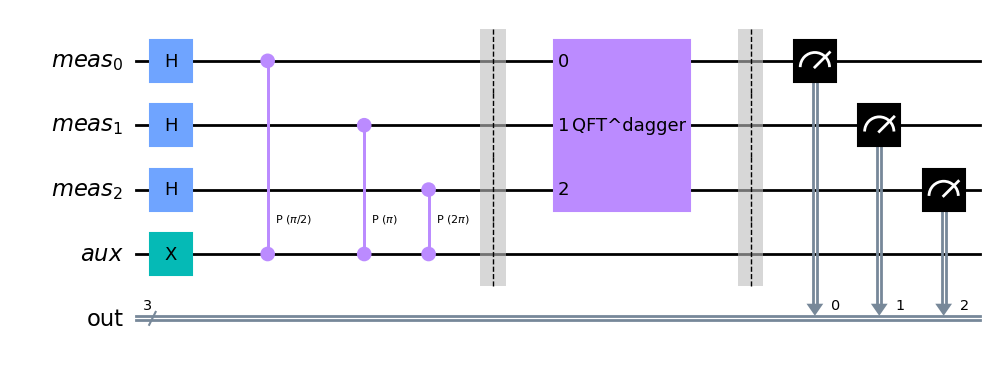

In [3]:
def qft_dagger(qreg):
    """逆量子フーリエ変換用の回路"""
    qc = QuantumCircuit(qreg)

    ##################
    ### EDIT BELOW ###
    ##################

    #qc.?

    ##################
    ### EDIT ABOVE ###
    ##################

    qc.name = "QFT^dagger"

    return qc

qc.barrier()
qc.append(qft_dagger(qreg_meas), qargs=qreg_meas)
qc.barrier()
qc.measure(qreg_meas, creg_meas)
qc.draw('mpl')

**解答**

````{toggle}

{ref}`fourier_addition`の`setup_addition`関数中のInverse QFTと書かれている部分を利用します。

```{code-block} python
def qft_dagger(qreg):
    """逆量子フーリエ変換用の回路"""
    qc = QuantumCircuit(qreg)

    ##################
    ### EDIT BELOW ###
    ##################

    for j in range(qreg.size // 2):
        qc.swap(qreg[j], qreg[-1 - j])

    for itarg in range(qreg.size):
        for ictrl in range(itarg):
            power = ictrl - itarg - 1
            qc.cp(-2. * np.pi * (2 ** power), ictrl, itarg)

        qc.h(itarg)

    ##################
    ### EDIT ABOVE ###
    ##################

    qc.name = "QFT^dagger"
    return qc
```

````

In [4]:
## テキスト作成用のセル

def qft_dagger(qreg):
    qc = QuantumCircuit(qreg)

    for j in range(qreg.size // 2):
        qc.swap(qreg[j], qreg[-1 - j])

    for itarg in range(qreg.size):
        for ictrl in range(itarg):
            power = ictrl - itarg - 1
            qc.cp(-2. * np.pi * (2 ** power), ictrl, itarg)

        qc.h(itarg)

    qc.name = "IQFT"
    return qc

qreg_meas = QuantumRegister(n_meas, name='meas')
qreg_aux = QuantumRegister(1, name='aux')
creg_meas = ClassicalRegister(n_meas, name='out')

qc = QuantumCircuit(qreg_meas, qreg_aux, creg_meas)

qc.h(qreg_meas)
qc.x(qreg_aux)

angle = np.pi / 2

for x, ctrl in enumerate(qreg_meas):
    qc.cp(angle * (2 ** x), ctrl, qreg_aux[0])

qc.append(qft_dagger(qreg_meas), qargs=qreg_meas)
qc.measure(qreg_meas, creg_meas)

(qpe_imp_simulator)=
### シミュレータでの実験

シミュレータで実行して、測定結果の確率分布を作ってみます。

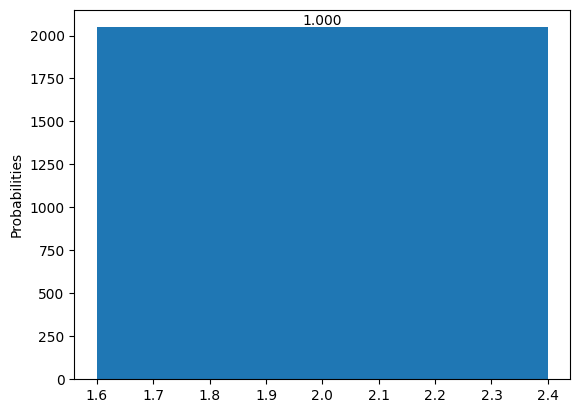

In [5]:
simulator = AerSimulator()
shots = 2048
qc_tr = transpile(qc, backend=simulator)
results = simulator.run(qc_tr, shots=shots).result()
answer = results.get_counts()

def show_distribution(answer):
    n = len(answer)
    x = [int(key, 2) for key in list(answer.keys())]
    y = list(answer.values())

    fig, ax = plt.subplots()
    rect = ax.bar(x,y)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height/sum(y):.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 0),
                        textcoords="offset points", ha='center', va='bottom')
    autolabel(rect)
    plt.ylabel('Probabilities')
    plt.show()

show_distribution(answer)

答えは10進数で2になっていますね。ここで測定した答えは$\ket{2^n\theta}$だったことを思い出すと、$\theta=2/2^3=1/4$となって正しい$\theta$が得られたことが分かります。

ここで見た量子回路はシンプルですが、いろいろ拡張して振る舞いを理解するのに役立ちます。例えば、以下の問題を調べてみてください。
- （グローバル因子を除いて）$S=P(\pi/2)$ゲートの例を見ましたが、角度を$0<\phi<\pi$の範囲で変えた$P(\phi)$ゲートではどうなるでしょうか？
- 角度の選び方によっては、得られる位相の精度が悪くなります。その場合、どうすればより良い精度で測定できるでしょうか？
- $S$ゲートの場合固有ベクトルは$\ket{1}$でしたが、$\ket{1}$以外の状態を使うとどうなりますか？特に固有ベクトルと線形従属なベクトルを使った場合の振る舞いを見てみてください。

(qpe_imp_real)=
### 量子コンピュータでの実験

最後に量子コンピュータで実行して、結果を確認してみましょう、以下のようにすることで、現時点でbusyでないマシンを優先的に選んで実行してくれます。

In [6]:
# 量子コンピュータで実行する場合
instance = 'ibm-q/open/main'

try:
    provider = IBMProvider(instance=instance)
except IBMQAccountCredentialsNotFound:
    provider = IBMProvider(token='__paste_your_token_here__', instance=instance)

backend_list = provider.backends(filters=operational_backend(min_qubits=4))
backend = least_busy(backend_list)
print(f"least busy backend: {backend.name()}")

NameError: name 'IBMQAccountCredentialsNotFound' is not defined

In [7]:
# 最も空いているバックエンドで回路を実行します。キュー内のジョブの実行をモニターします。
qc_tr = transpile(qc, backend=backend, optimization_level=3)
job = backend.run(qc_tr, shots=shots)
job_monitor(job, interval=2)

NameError: name 'backend' is not defined

In [8]:
# 計算結果
results = job.result()
answer = results.get_counts()
show_distribution(answer)

NameError: name 'job' is not defined

(shor_algo)=
## ショアのアルゴリズム

では、そろそろ本題であるショアのアルゴリズムに入っていきましょう。ショアのアルゴリズムが考えるのは「ある正の合成数$N$を、自明ではない素数の積$N=qp$に分解する」という問題です。

まず、整数の剰余についての表記法をおさらいしておきます。以下のような整数$x$の並びを考えたとき、例えば3で割った余りを$y$とすると

|x|0|1|2|3|4|5|6|7|8|9|
|-|-|-|-|-|-|-|-|-|-|-|
|y|0|1|2|0|1|2|0|1|2|0|

ですね。この時、$\modequiv{x}{y}{3}$と書くものとします（$k$を0以上の整数とすれば、$x=3k+y$と書くこともできます）。

ショアのアルゴリズムの流れを書くと、以下のようなフローチャートになります。黒字の部分は古典計算で実行し、青地の部分を量子コンピュータで実行することになります。「アルゴリズムの一部でしか量子計算を使わないのはなぜ？」と思うかもしれませんが、この青地の部分を古典計算で実行するのが難しいというのがその理由です。つまり、古典計算で十分なところは古典計算にまかして、古典計算では難しい部分を量子計算で実行するというのがその発想の大元にあります。なぜ青地の部分が古典計算では難しいのかは追々明らかになります。

(shor_algo_fig)=
```{image} figs/shor_flow.png
:alt: shor_flow
:width: 500px
:align: center
```

(factoring_example)=
### 素因数分解の例
簡単な例として、$N=15$の素因数分解をこのアルゴリズムに沿って考えてみましょう。

例えば、15に素な数として仮に$a=7$を選んだとします。そこで$7^x$を15で割った余りを$y$とすると

|x|0|1|2|3|4|5|6|$\cdots$|
|-|-|-|-|-|-|-|-|-|
|y|1|7|4|13|1|7|4|$\cdots$|

のようになります。つまり、$\modequiv{7^r}{1}{15}$を満たす最小の非自明な$r$は4になることが分かります。
$r=4$は偶数なので、$\modequiv{x}{7^{4/2}}{15}$が定義でき、$x=4$です。$x+1 = \modnequiv{5}{0}{15}$なので、

$$
\{p,q\}=\{\gcd(5,15), \gcd(3,15)\}=\{5,3\}
$$

となって、$15=5\times3$が得られました!

(shor_circuit)=
### 量子回路

では次に、$N=15$の素因数分解を実装する量子回路を考えていきましょう。いきなり答えを書いてしまうようですが、回路自体は以下のような構成をしています。

(shor_circuit_fig)=
```{image} figs/shor.png
:alt: shor
:width: 700px
:align: center
```

上段にある4個の量子ビットが測定用のレジスタ、下段の4個の量子ビットが作業用のレジスタに対応します。それぞれのレジスタが4つずつなのは、15が4ビット（$n=4$）で表現できるからです（15の2進数表記 = $1111_2$）。状態は全て$\ket{0}$に初期化されているものとして、測定用レジスタの状態を$\ket{x}$、作業用レジスタの状態を$\ket{w}$とします。
$U_f$は以下のようなオラクル

```{image} figs/shor_oracle2.png
:alt: shor_oracle2
:width: 300px
:align: center
```

で、作業用レジスタの出力状態が$\ket{w\oplus f(x)}$になるものと理解しておきます（詳細は後で説明します）。関数$f(x)$は$f(x) = a^x \bmod N$とします。

では、同様に回路のステップ 1-5ごとに量子状態を見ていきましょう。まずステップ 1で測定用量子レジスタの等しい重ね合わせ状態を生成します。各計算基底は0から15までの整数で書いておくことにします。

- ステップ 1 :$\frac{1}{\sqrt{2^4}}\left[\sum_{j=0}^{2^4-1}\ket{j}\right]\ket{0}^{\otimes 4} = \frac{1}{4}\left[\ket{0}+\ket{1}+\cdots+\ket{15}\right]\ket{0}^{\otimes 4}$

オラクル$U_f$を適用した後の状態は、オラクルの定義から以下のようになります。

- ステップ 2 :

$$
\begin{aligned}
&\frac{1}{4}\left[\ket{0}\ket{0 \oplus (7^0 \bmod 15)}+\ket{1}\ket{0 \oplus (7^1 \bmod 15)}+\cdots+\ket{15}\ket{0 \oplus (7^{15} \bmod 15)}\right]\\
=&\frac{1}{4}\left[\ket{0}\ket{1}+\ket{1}\ket{7}+\ket{2}\ket{4}+\ket{3}\ket{13}+\ket{4}\ket{1}+\cdots+\ket{15}\ket{13}\right]
\end{aligned}
$$

ステップ 2の後に作業用レジスタを測定します。$\ket{w}$は$\ket{7^x \bmod 15}$、つまり$\ket{1}$, $\ket{7}$, $\ket{4}$, $\ket{13}$のどれかなので、例えば測定の結果13が得られたとします。その場合、測定用レジスタの状態は

- ステップ 3 :$\frac{1}{2}\left[\ket{3}+\ket{7}+\ket{11}+\ket{15}\right]$

となります。次に、測定用レジスタに逆量子フーリエ変換$\rm{QFT}^\dagger$を適用します。逆量子フーリエ変換はある状態$\ket{j}$を$\ket{j} \to \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}e^{\frac{-2\pi ijk}{N}}\ket{k}$に変換するので、

- ステップ 4 :

$$
\begin{aligned}
&\frac{1}{2}\mathrm{QFT}^\dagger\left[\ket{3}+\ket{7}+\ket{11}+\ket{15}\right]\\
=&\frac{1}{2}\frac1{\sqrt{2^4}}\sum_{k=0}^{2^4-1}\left[e^{\frac{-2\pi i\cdot3k}{2^4}}+e^{\frac{-2\pi i\cdot7k}{2^4}}+e^{\frac{-2\pi i\cdot11k}{2^4}}+e^{\frac{-2\pi i\cdot15k}{2^4}}\right]\ket{k}\\
=&\frac{1}{8}\left[4\ket{0}+4i\ket{4}-4\ket{8}-4i\ket{12}\right]
\end{aligned}
$$

となります。ここで、状態として$\ket{0}$, $\ket{4}$, $\ket{8}$, $\ket{12}$しか出てこないところが鍵で、量子状態の干渉を使って不要な答えの振幅を小さくしているわけです。

- ステップ 5 :最後に測定用レジスタを測定すると、0, 4, 8, 12がそれぞれ1/4の確率で得られます。

ステップ 2で$7^x \bmod 15$を計算しているので想像がつきますが、すでに繰り返しの兆候が現れていますね。

(shor_measurement)=
### 測定結果の解析

この測定結果の意味を考察してみましょう。ショアのアルゴリズムの{ref}`回路 <shor_circuit_fig>`と$n$量子ビット位相推定の{ref}`回路 <qpe_nqubit_fig>`の類似性から、ここではこの2つが同一の働きをするものと仮定してみます（以下で補足説明します）。その場合、測定用レジスタは固有値$e^{2\pi i\theta}$の位相$\theta$を$2^4=16$倍したものになっているはずです。つまり、例えば測定用レジスタを測定した結果が仮に4の場合、位相$\theta$は$\theta=4/16=0.25$です。この位相の値は何を意味しているのでしょうか？

ショアのアルゴリズムの量子回路として、これまで$\ket{w}=\ket{0}^{\otimes n}$を初期状態として、$U_f\ket{x}\ket{w}=\ket{x}\ket{w\oplus f(x)}$ $(f(x) = a^x \bmod N)$ となるオラクル$U_f$を考えてきました。この$U_f$を実装するために、以下のようなユニタリー演算子$U$を考えてみます。

```{math}
:label: U_action
U\ket{m} =
\begin{cases}
\ket{am \bmod N)} & 0 \leq m \leq N - 1 \\
\ket{m} & N \leq m \leq 2^n-1
\end{cases}
```

このユニタリーは、

$$
U^{x}\ket{1} = U^{x-1} \ket{a \bmod N} = U^{x-2} \ket{a^2 \bmod N} = \cdots = \ket{a^x \bmod N}
$$

を満たすので、$w=0$とした$U_f\ket{x}\ket{0}$を$U$を使って実装することができます。

$$
\begin{aligned}
U_f\ket{x}\ket{0}&=\ket{x}\ket{0 \oplus (a^x \bmod N)}\\
&=\ket{x}\ket{a^x \bmod N}\\
&=\ket{x} U^x \ket{1}
\end{aligned}
$$

ここで、天下り的ではありますが

$$
\ket{\psi_s} \equiv \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1}e^{-2\pi isk/r}\ket{a^k \bmod N}
$$

（$s$は$0 \leq s \leq r-1$の整数）となるベクトル$\ket{\psi_s}$を定義すると、

$$
\frac{1}{\sqrt{r}}\sum_{s=0}^{r-1}\ket{\psi_s}=\ket{1}
$$

が導けると同時に、$\ket{\psi_s}$は$U$の固有ベクトルであり、固有値$e^{2\pi is/r}$を持つことが分かります。

$$
U\ket{\psi_s}=e^{2\pi is/r}\ket{\psi_s}
$$

つまり、ショアのアルゴリズムのオラクル$U_f$による操作は、固有値$e^{2\pi is/r}$を持つ固有ベクトル$\ket{\psi_s}$の重ね合わせ状態$\ket{1}$にユニタリー$U$を$x$回適用することと同等なわけです。量子位相推定の{ref}`回路 <qpe_nqubit_fig>`と比較すれば、やっていることはほぼ同じですね。その後に逆QFTを掛けるということまで考えれば、まさにQPEそのものの操作を行っていることに対応しています。

QPEで得られる位相は何だったかを思い出すと、それは$U\ket{\psi}=e^{2\pi i\theta}\ket{\psi}$なるユニタリー演算$U$と固有ベクトル$\ket{\psi}$に対する固有値$e^{2\pi i\theta}$に含まれる位相$\theta$でした。以上のことから、ショアのアルゴリズムから得られる位相$\theta$は、$s/r$（の整数倍）の意味を持つことも分かるでしょう。

(continued_fractions)=
### 連分数展開
以上の考察から、測定の結果得られる位相は$\theta \approx s/r$であることが分かりました。この結果から位数$r$を求めるために**連分数展開**という手法を使いますが、詳細は他の文献に委ねます（{cite}`nielsen_chuang_qft_app`にもp.230に記述があります）。この手法を使うことで、$\theta$に最も近い分数として$s/r$を求めることができます。

例えば$\theta=0.25$の場合、$r=4$が得られます（頻度は小さいですが$r=8$が得られる可能性もあります）。ここまでできれば、あとは古典計算のみで求める素因数に分解することができますね（{ref}`ここ <factoring_example>`を参照）。

(modular_exponentiation)=
### 剰余指数化
オラクル$U_f$による操作$U_f\ket{x}\ket{w}=\ket{x}\ket{w\oplus f(x)}$とはどういうものか、もう少し考えてみましょう。$f(x) = a^x \bmod N$は、$x$の2進数表記

$$
x=(x_{n-1}x_{n-2}\cdots x_0)_2 = 2^{n-1}x_{n-1}+2^{n-2}x_{n-2}+\cdots+2^0x_0
$$

を使って

$$
\begin{aligned}
f(x) & = a^x \bmod N \\
 & = a^{2^{n-1}x_{n-1}+2^{n-2}x_{n-2}+\cdots+2^0x_0} \bmod N \\
 & = a^{2^{n-1}x_{n-1}}a^{2^{n-2}x_{n-2}}\cdots a^{2^0x_0} \bmod N
\end{aligned}
$$

と書くことができます。つまり、この関数は以下のようなユニタリー演算を考えれば実装することができます。

```{image} figs/shor_oracle.png
:alt: shor_oracle
:width: 600px
:align: center
```

$n$量子ビットQPEの{ref}`回路 <qpe_nqubit_fig>`と比較すれば、このユニタリーはQPEの$U^{2^x}$演算を実装しているものだと分かるでしょう。このように、第2レジスタ（上図では一番下のワイヤに繋がるレジスタ）の内容に、第1レジスタの各ビットで制御された$a^x \bmod N$を適用してQPEの$U^{2^x}$演算を実現する手法を、**剰余指数化**と呼びます。

(shor_imp)=
## アルゴリズムの実装
ここから、ショアのアルゴリズムを実装していきます。

(shor_imp_period)=
### 位数の発見

まず最初に、繰り返しの位数（周期）を発見するアルゴリズムを見てみます。

$N$を正の整数として、関数$f(x) = a^x \bmod N$の振る舞いを考えます。[ショアのアルゴリズム](shor_algo_fig)に立ち返ってみると、
ここで$a$は$N$と互いに素な$N$未満の正の整数で、位数$r$は$\modequiv{a^r}{1}{N}$を満たす非ゼロの最小の整数でした。
以下のグラフにこの関数の例を示します。 ポイント間の線は周期性を確認するためのものです。

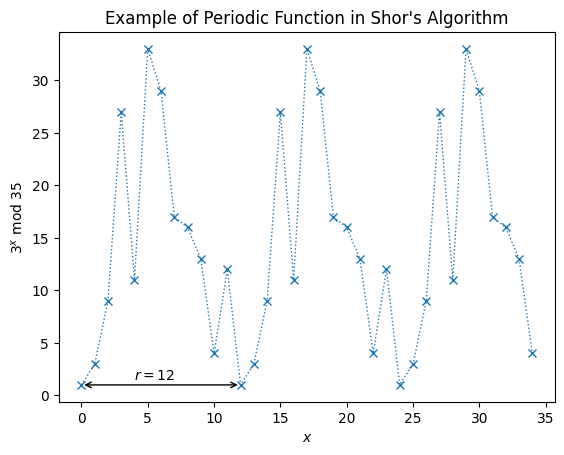

In [9]:
N = 35
a = 3

# プロットするデータを計算する
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# matplotlibを使って描画
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod {N}',
       title="Example of Periodic Function in Shor's Algorithm")

try: # グラフ上にrをプロット
    r = yvals[1:].index(1) + 1
except ValueError:
    print('Could not find period, check a < N and have no common factors.')
else:
    plt.annotate(text='', xy=(0, 1), xytext=(r, 1), arrowprops={'arrowstyle': '<->'})
    plt.annotate(text=f'$r={r}$', xy=(r / 3, 1.5))

(shor_imp_oracle)=
### オラクルの実装

以下では、$N=15$を素因数に分解してみます。上で説明したように、$U\ket{m}=\ket{am \bmod N}$となるユニタリー$U$を$x$回繰り返すことで、オラクル$U_f$を実装します。

練習問題として、$C[U^{2^l}] \ket{z} \ket{m}=\ket{z} \ket{a^{z 2^{l}} m \bmod 15} \; (z=0,1)$を実行する関数`c_amod15`を以下に実装してください（`c_amod15`全体は制御ゲートを返しますが、標的レジスタのユニタリー演算、特に$U$に対応する部分を書いてください）。

関数の引数`a`は15より小さく15と互いに素な整数のみを考えます。また、実は一般に$a = N-1$の場合、$\modequiv{a^2}{1}{N}$なので位数$r$は2、したがって$a^{r/2} = a$、$\modequiv{a + 1}{0}{N}$となり、ショアのアルゴリズムには使えないことが分かります。したがって、考えるべき`a`の値は13以下です。

一般の$a$と$N$についてこのようなユニタリを作るには非常に込み入った回路が必要になりますが{cite}`shor_oracle`、$N=15$に限った場合は数行のコードで実装できます。

In [10]:
def c_amod15(a, l):
    """mod 15による制御ゲート"""

    if a not in [2, 4, 7, 8, 11, 13]:
        raise ValueError("'a' must be 2, 4, 7, 8, 11, or 13")

    U = QuantumCircuit(4)

    ##################
    ### EDIT BELOW ###
    ##################

    #if a == 2:
    #    ...
    #elif a == 4:
    #    ...
    #    ...

    ##################
    ### EDIT ABOVE ###
    ##################

    # Uを2^l回繰り返す
    U_power = U.repeat(2 ** l)

    # U_powerをゲートに変換
    gate = U_power.to_gate()
    gate.name = f"{a}^{2 ** l} mod 15"

    # gateを制御ゲートに変換
    c_gate = gate.control()
    return c_gate

**解答**

````{toggle}
まず、`a=2, 4, 8`のケースを考えます。$m$を二進数分解して

```{math}
m=\sum_{j=0}^{3} 2^j m_j \, (m_j=0,1)
```

とすると、

```{math}
:label: ammod15
am \bmod 15 = \left( \sum_{j=0}^{3} 2^{j+\log_2 a} m_j \right) \bmod 15
```

ですが、$15 = 2^4 - 1$で、一般に自然数$n, m$と$n-pm < m$となる最小の自然数$p$について

```{math}
2^n \bmod (2^m - 1) = 2^{n-pm}
```

が成り立つので（証明は簡単なので考えてみてください）、$2^{j+\log_2 a} \bmod 15$は$j=0, 1, 2, 3$に対して値$1, 2, 4, 8$をそれぞれ一度だけ取ります。

したがって$m \leq 14$に対しては式{eq}`ammod15`の右辺の括弧の各項について15の剰余を取っても和が15以上にならないので

```{math}
am \bmod 15 = \sum_{j=0}^{3} (2^{j+\log_2 a} \bmod 15) m_j,
```

つまり、$a$倍して15での剰余を取る操作を各ビットに対して独立に考えて良いことがわかります。そこで実際に$2^{j+\log_2 a} \bmod 15$の値を書き出してみると

|       | $j=0$ | $j=1$ | $j=2$ | $j=3$ |
|-------|-------|-------|-------|-------|
| $a=2$ | 2     |  4    | 8     | 1     |
| $a=4$ | 4     |  8    | 1     | 2     |
| $a=8$ | 8     |  1    | 2     | 4     |

となります。このような作用はサイクリックなビットシフトとして記述でき、例えば`a=2`なら

```{math}
\begin{align}
0001 & \rightarrow 0010 \\
0010 & \rightarrow 0100 \\
0100 & \rightarrow 1000 \\
1000 & \rightarrow 0001
\end{align}
```

となればいいので、量子回路としてはSWAPゲートを利用して実装できます。

```{code-block} python
    ##################
    ### EDIT BELOW ###
    ##################

    if a == 2:
        # 下の位を上に移すので、上の位から順にSWAPしていく
        U.swap(3, 2)
        U.swap(2, 1)
        U.swap(1, 0)
    elif a == 4:
        # 「一つ飛ばし」のビットシフト
        U.swap(3, 1)
        U.swap(2, 0)
    elif a == 8:
        # 下から順
        U.swap(1, 0)
        U.swap(2, 1)
        U.swap(3, 2)

    ##################
    ### EDIT ABOVE ###
    ##################
```

このようにSWAPゲートを利用すると、おまけの利点として、$m=15$の場合は$U$がレジスタの状態を変えないので、式{eq}`U_action`が正しく実現されることになります。ただ、下でこの関数を実際に使う時には、作業用レジスタに$\ket{15}$という状態が現れることは実はないので、この点はあまり重要ではありません。

残りの`a=7, 11, 13`はどうでしょうか。ここでも15という数字の特殊性が発揮されます。$7 = 15 - 8$、$11 = 15 - 4$、$13 = 15 - 2$であることに着目すると、

```{math}
\begin{align}
7m \bmod 15 & = (15 - 8)m \bmod 15 = 15 - (8m \bmod 15) \\
11m \bmod 15 & = (15 - 4)m \bmod 15 = 15 - (4m \bmod 15) \\
13m \bmod 15 & = (15 - 2)m \bmod 15 = 15 - (2m \bmod 15),
\end{align}
```

つまり、上の`a=2, 4, 8`のケースの結果を15から引くような回路を作ればいいことがわかります。そして、4ビットのレジスタにおいて15から値を引くというのは、全てのビットを反転させる（$X$ゲートをかける）ことに対応するので、最終的には

```{code-block} python
    ##################
    ### EDIT BELOW ###
    ##################

    if a in [2, 13]:
        # 下の位を上に移すので、上の位から順にSWAPしていく
        U.swap(3, 2)
        U.swap(2, 1)
        U.swap(1, 0)
    elif a in [4, 11]:
        # 「一つ飛ばし」のビットシフト
        U.swap(3, 1)
        U.swap(2, 0)
    elif a in [8, 7]:
        # 下から順
        U.swap(1, 0)
        U.swap(2, 1)
        U.swap(3, 2)

    if a in [7, 11, 13]:
        U.x([0, 1, 2, 3])

    ##################
    ### EDIT ABOVE ###
    ##################
```

が正解です。
````

In [11]:
# テキスト作成用のセル

def c_amod15(a, l):
    U = QuantumCircuit(4, name='U')

    if a in [2, 13]:
        U.swap(3, 2)
        U.swap(2, 1)
        U.swap(1, 0)
    elif a in [4, 11]:
        U.swap(3, 1)
        U.swap(2, 0)
    elif a in [8, 7]:
        U.swap(1, 0)
        U.swap(2, 1)
        U.swap(3, 2)

    if a in [7, 11, 13]:
        U.x([0, 1, 2, 3])

    U_power = U.repeat(2 ** l)

    gate = U_power.to_gate()
    gate.name = f"{a}^{2 ** l} mod 15"
    c_gate = gate.control()
    return c_gate

(shor_imp_circuit)=
### 回路全体の実装

測定用ビットとして、8量子ビットを使います。

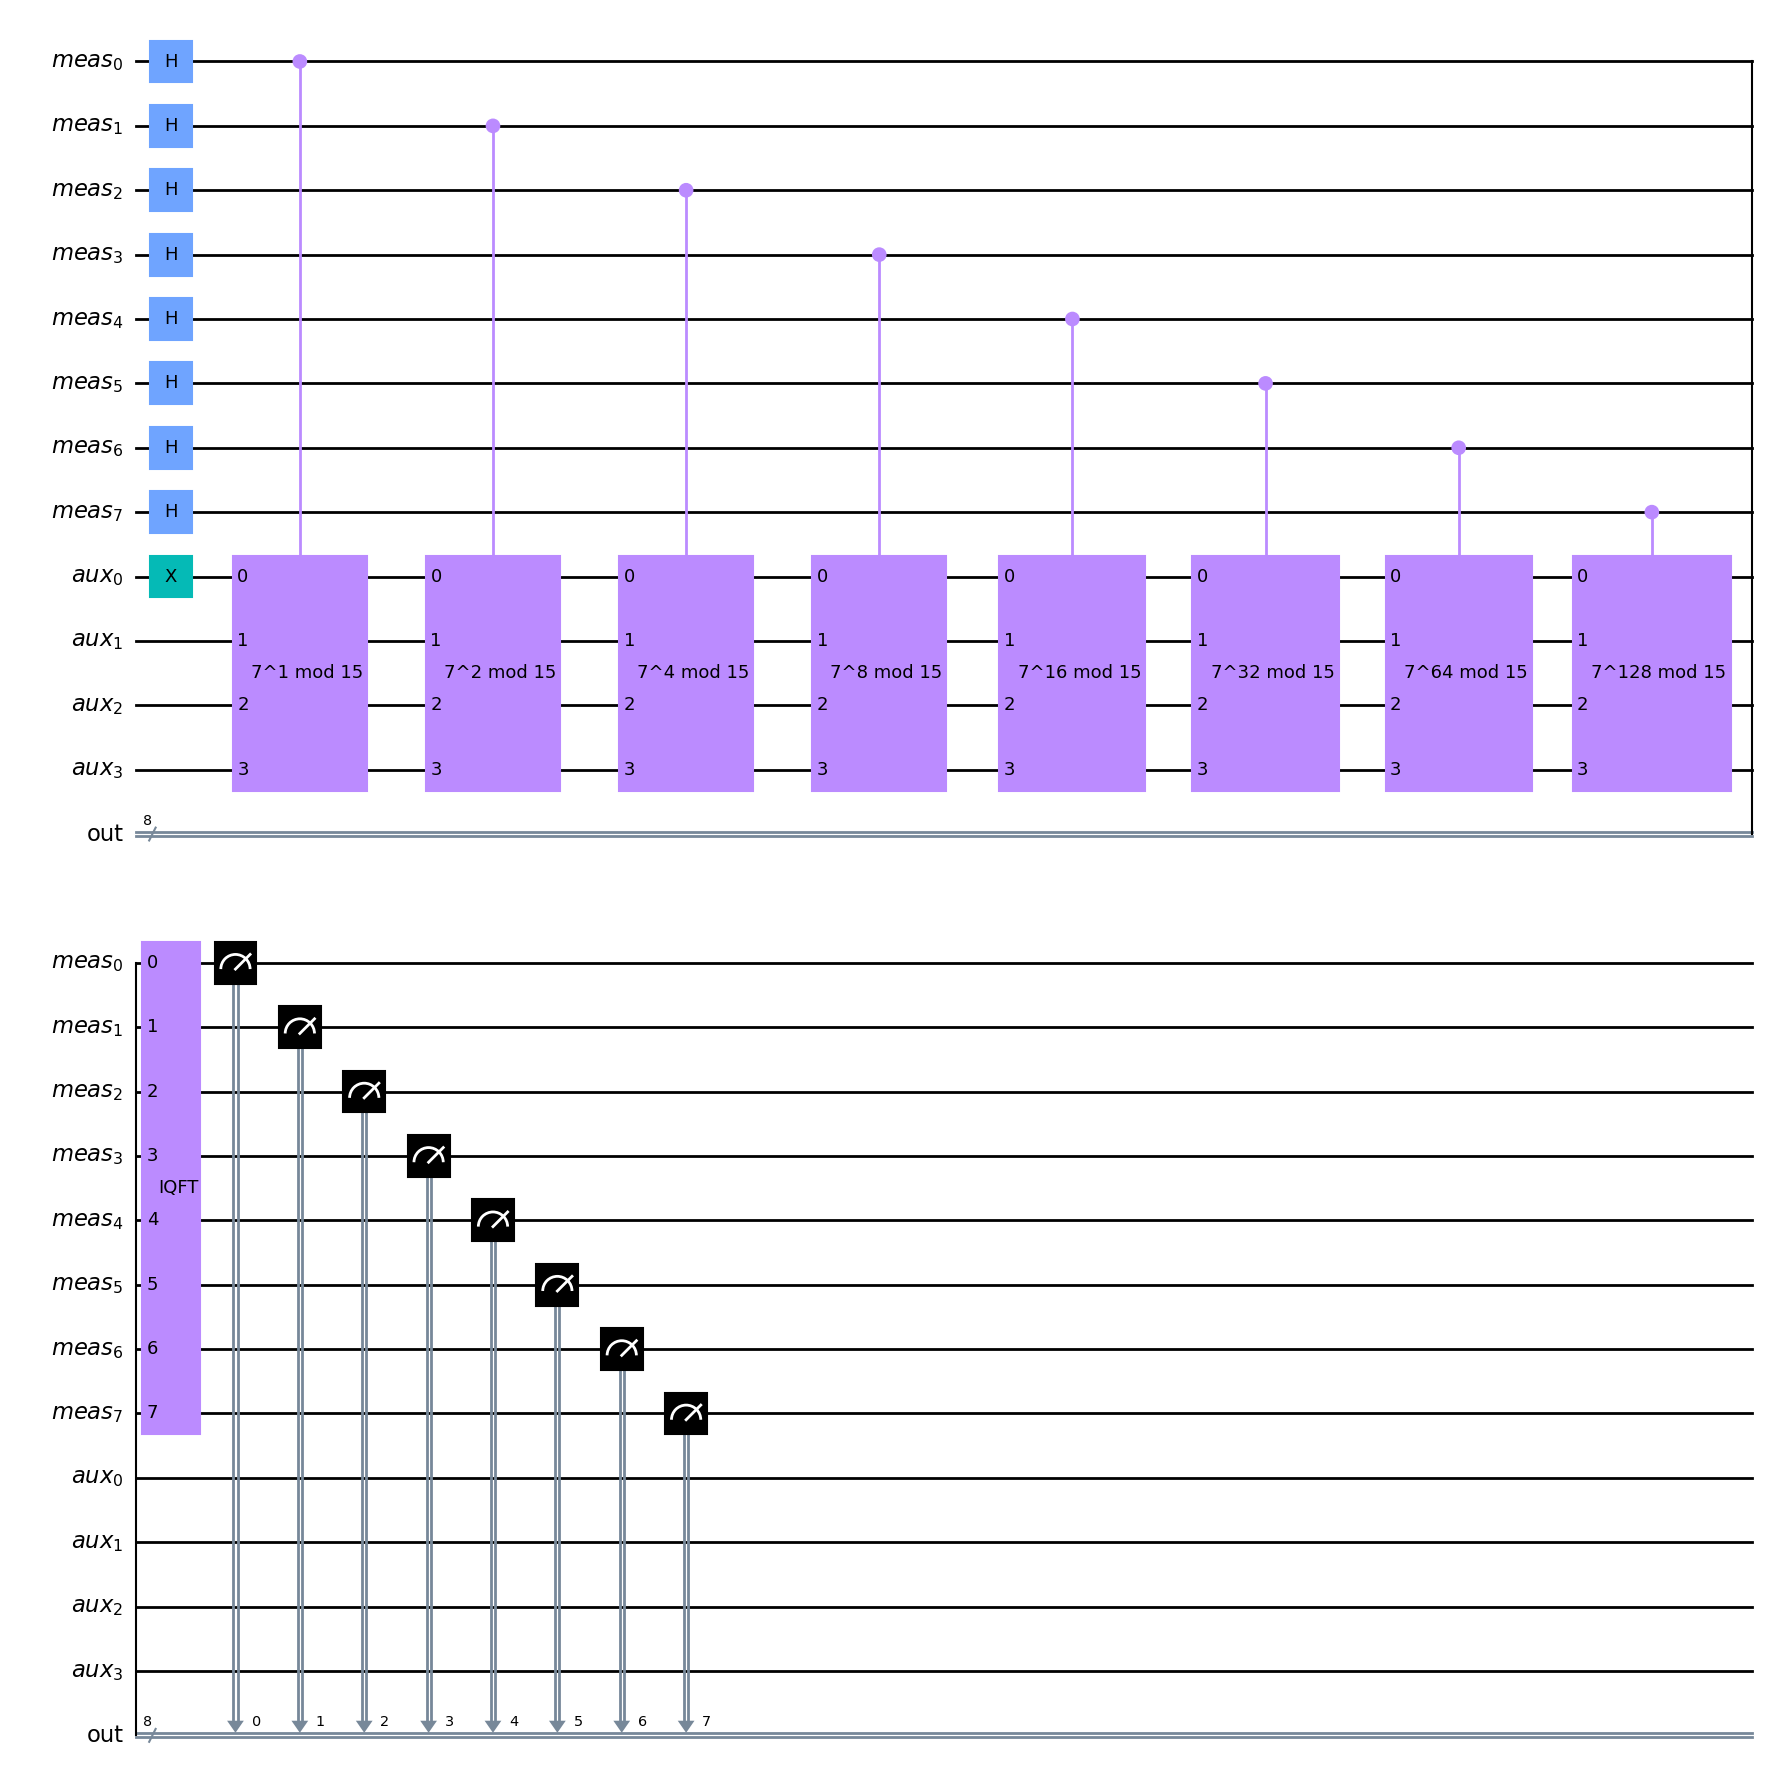

In [12]:
# 15と互いに素な数
a = 7

# 測定用ビットの数（位相推定の精度）
n_meas = 8

# 位相測定用のレジスタ
qreg_meas = QuantumRegister(n_meas, name='meas')
# Uを作用させる作業用レジスタ
qreg_aux = QuantumRegister(4, name='aux')
# 位相測定の結果が書き出される古典レジスタ
creg_meas = ClassicalRegister(n_meas, name='out')

# 2つの量子レジスタと1つの古典レジスタから量子回路を作る
qc = QuantumCircuit(qreg_meas, qreg_aux, creg_meas)

# 測定用レジスタをequal superpositionに初期化
qc.h(qreg_meas)
# 作業用レジスタを|1>に初期化
qc.x(qreg_aux[0])

# 制御Uゲートを適用
for l, ctrl in enumerate(qreg_meas):
    qc.append(c_amod15(a, l), qargs=([ctrl] + qreg_aux[:]))

# 逆QFTを適用
qc.append(qft_dagger(qreg_meas), qargs=qreg_meas)

# 回路を測定
qc.measure(qreg_meas, creg_meas)
qc.draw('mpl')

シミュレータで実行して、結果を確認してみます。

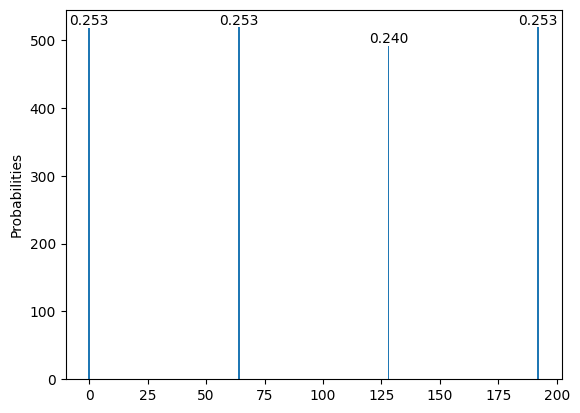

In [13]:
qc = transpile(qc, backend=simulator)
results = simulator.run(qc, shots=2048).result()
answer = results.get_counts()

show_distribution(answer)

(shor_imp_ana)=
### 計算結果の解析
出力された結果から、位相を求めてみます。

In [14]:
rows, measured_phases = [], []
for output in answer:
    decimal = int(output, 2)  # 10進数に変換
    phase = decimal / (2 ** n_meas)
    measured_phases.append(phase)
    # これらの値をテーブルの行に追加：
    rows.append(f"{decimal:3d}      {decimal:3d}/{2 ** n_meas} = {phase:.3f}")

# 結果を表示
print('Register Output    Phase')
print('------------------------')

for row in rows:
    print(row)

Register Output    Phase
------------------------
128      128/256 = 0.500
192      192/256 = 0.750
  0        0/256 = 0.000
 64       64/256 = 0.250


得られた位相の情報から、連分数アルゴリズムを使用して$s$と$r$を見つけることができます。Pythonの組み込みの`fractions`(分数)モジュールを使用して、小数を`Fraction`オブジェクトに変換できます。

In [15]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append(f'{phase:10.3f}      {frac.numerator:2d}/{frac.denominator:2d} {frac.denominator:13d}')

# 結果を表示
print('     Phase   Fraction   Guess for r')
print('-------------------------------------')

for row in rows:
    print(row)

     Phase   Fraction   Guess for r
-------------------------------------
     0.500       1/ 2             2
     0.750       3/ 4             4
     0.000       0/ 1             1
     0.250       1/ 4             4


`limit_denominator`メソッドを使って、分母が特定の値（ここでは15）を下回る分数で、最も位相の値に近いものを得ています。

測定された結果のうち、2つ（64と192）が正しい答えである$r=4$を与えたことが分かります。